In [3]:
# imports

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
# images path
image_path = "images"

# csv file
faces_data = pd.read_csv("faces.csv")
data = faces_data.copy()
data.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [5]:
# no duplicates and null values

In [6]:
#Full path of image
data["image_name"] = data["image_name"].apply(lambda x : os.path.join(image_path, x))
data.head()

,image_name,width,height,x0,y0,x1,y1
0,images/00001722.jpg,1333,2000,490,320,687,664
1,images/00001044.jpg,2000,1333,791,119,1200,436
2,images/00001050.jpg,667,1000,304,155,407,331
3,images/00001736.jpg,626,417,147,14,519,303
4,images/00003121.jpg,626,418,462,60,599,166


In [7]:
# Normalizing x0,y0,x1,y1
data["x0"] = data["x0"]/data["width"]
data["y0"] = data["y0"]/data["height"]
data["x1"] = data["x1"]/data["width"]
data["y1"] = data["y1"]/data["height"]

In [8]:
def preprocessing(file_path, label, pred=False):

    img = tf.io.read_file(file_path)   #read the content of file
    img= tf.io.decode_jpeg(img, channels=3)  #convert image into tensor
    height_img = img.shape[0]
    width_img = img.shape[1]
    img  = tf.image.resize(img, [224,224])   #resize the image
    img  = tf.cast(img, tf.float32)/255.0    #Normalize the element of img tensor
    if pred:
        return img, width_img, height_img
    return img, label

In [9]:
#creating the dataset

def to_dataset(data):
    data_set = tf.data.Dataset.from_tensor_slices((data["image_name"],data.drop(columns = ["image_name","width","height"])))
    dataset = data_set.map(preprocessing)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [10]:
# Count the total number of unique images
total_images = data['image_name'].nunique()

# Count the total number of faces (bounding boxes)
total_faces = len(data)

print(f"Total number of images: {total_images}")
print(f"Total number of faces: {total_faces}")

Total number of images: 2204
Total number of faces: 3350


In [11]:
# Group the data by image name and count the number of faces per image
faces_per_image = data.groupby('image_name').size().reset_index(name='face_count')

# Display the face count per image
print(faces_per_image)

# Additional analysis: Calculate the overall statistics for face density
average_faces_per_image = faces_per_image['face_count'].mean()
max_faces_per_image = faces_per_image['face_count'].max()
min_faces_per_image = faces_per_image['face_count'].min()


print(f"Average number of faces per image: {average_faces_per_image:.2f}")
print(f"Maximum number of faces per image: {max_faces_per_image}")
print(f"Minimum number of faces per image: {min_faces_per_image}")

               image_name  face_count
0     images/00000003.jpg           1
1     images/00000004.jpg           1
2     images/00000005.jpg           1
3     images/00000006.jpg           1
4     images/00000008.jpg           1
...                   ...         ...
2199  images/00003507.jpg           1
2200  images/00003510.jpg           2
2201  images/00003513.jpg           1
2202  images/00003514.jpg           1
2203  images/00003517.jpg           4

[2204 rows x 2 columns]
Average number of faces per image: 1.52
Maximum number of faces per image: 12
Minimum number of faces per image: 1


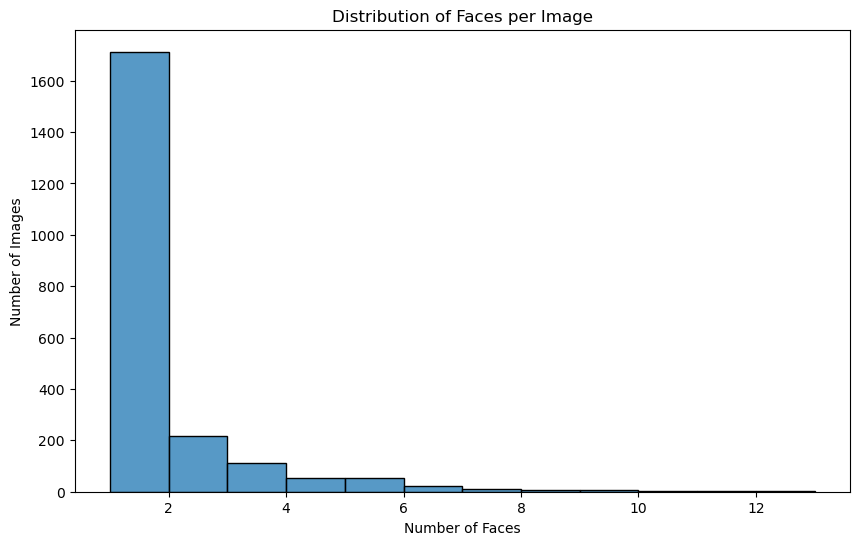

In [12]:
# Visualize the distribution of face counts per image
plt.figure(figsize=(10, 6))
sns.histplot(faces_per_image['face_count'], bins=range(1, max_faces_per_image + 2), kde=False)
plt.title('Distribution of Faces per Image')
plt.xlabel('Number of Faces')
plt.ylabel('Number of Images')
plt.show()

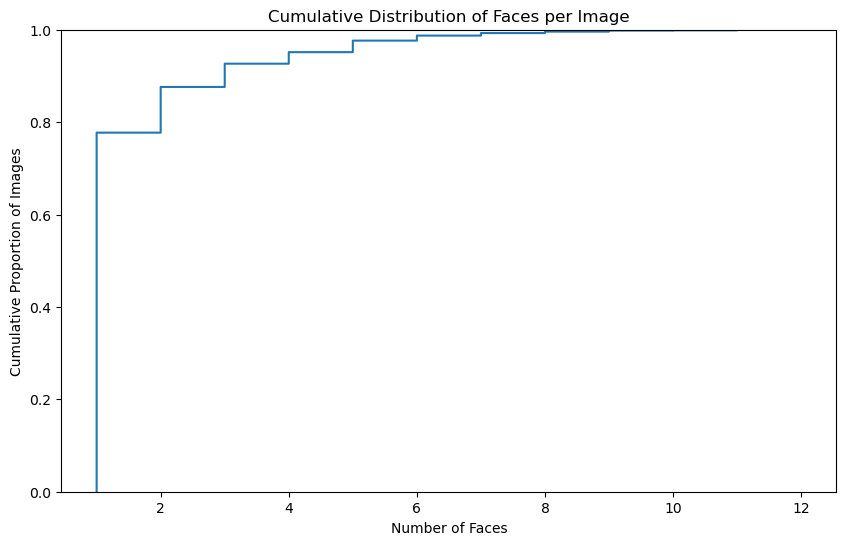

In [13]:
# Visualize the cumulative distribution of face counts per image
plt.figure(figsize=(10, 6))
sns.ecdfplot(faces_per_image['face_count'])
plt.title('Cumulative Distribution of Faces per Image')
plt.xlabel('Number of Faces')
plt.ylabel('Cumulative Proportion of Images')
plt.show()

In [15]:
# Split the data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Verify the split
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 2680
Test set size: 670


In [17]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Transfer learning (using pretrained model Restnet50)
re_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    # input_tensor=None,
    input_shape=(224,224,3)
)


2024-08-22 15:37:04.359262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#creating the model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

# Build the model
x = re_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D to reduce dimensions
x = Dense(250, activation="relu")(x)
x = Dense(250, activation="relu")(x)
output = Dense(4, activation="linear")(x)  # Assuming 4 output classes or regression outputs

model = Model(inputs=re_model.input, outputs=output)


In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Adjust based on your specific problem
              metrics=['accuracy'])

In [20]:
# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
# Create datasets
train_dataset = to_dataset(train_df)
test_dataset = to_dataset(test_df)

In [22]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2,  # Adjust based on your needs
    verbose=1
)

Epoch 1/2
84/84 [==============================] - 1660s 19s/step - loss: 0.1062 - accuracy: 0.7164 - val_loss: 0.0413 - val_accuracy: 0.6284
Epoch 2/2
84/84 [==============================] - 1519s 18s/step - loss: 0.0205 - accuracy: 0.7668 - val_loss: 0.0311 - val_accuracy: 0.7955


In [34]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

21/21 [==============================] - 119s 6s/step - loss: 0.0311 - accuracy: 0.7955
Test Loss: 0.031129663810133934
Test Accuracy: 0.7955223917961121


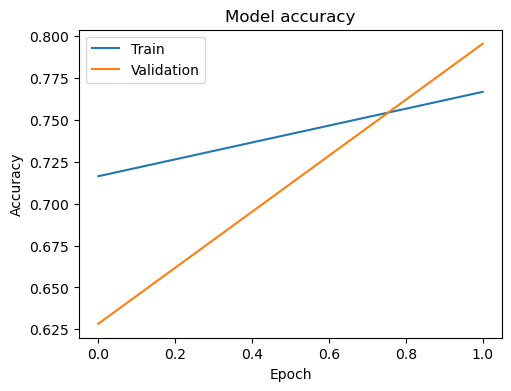

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

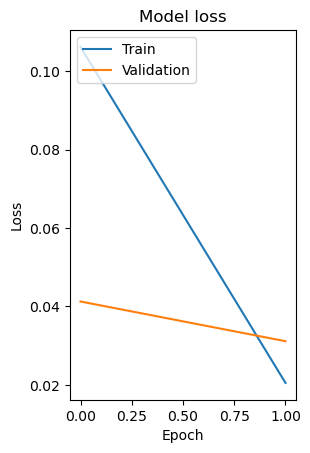

In [25]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [26]:
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on the test dataset
y_true = []
y_pred = []

for image, label in test_dataset.unbatch():
    y_true.append(label.numpy())
    y_pred.append(model.predict(tf.expand_dims(image, axis=0)).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)




1/1 [==============================] - 0s 185ms/step


In [27]:
# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()
mse = mean_squared_error(y_true_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.031129665800865007


In [28]:
# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1, yi1, xi2, yi2 = max(x1, x1g), max(y1, y1g), min(x2, x2g), min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou

ious = []
for i in range(len(y_true)):
    iou = calculate_iou(y_true[i], y_pred[i])
    ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean Intersection over Union (IoU): {mean_iou}")

Mean Intersection over Union (IoU): 0.16561382330424804


In [29]:
# Save the model in the native Keras format
model.save("my_model.keras")


In [30]:
# Load the model
from tensorflow.keras.models import load_model

loaded_model = load_model("my_model.keras")


In [31]:
def preprocessing(file_path, label, pred=False):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    height_img = img.shape[0]
    width_img = img.shape[1]
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    if pred:
        return img, width_img, height_img
    return img, label


1/1 [==============================] - 0s 180ms/step


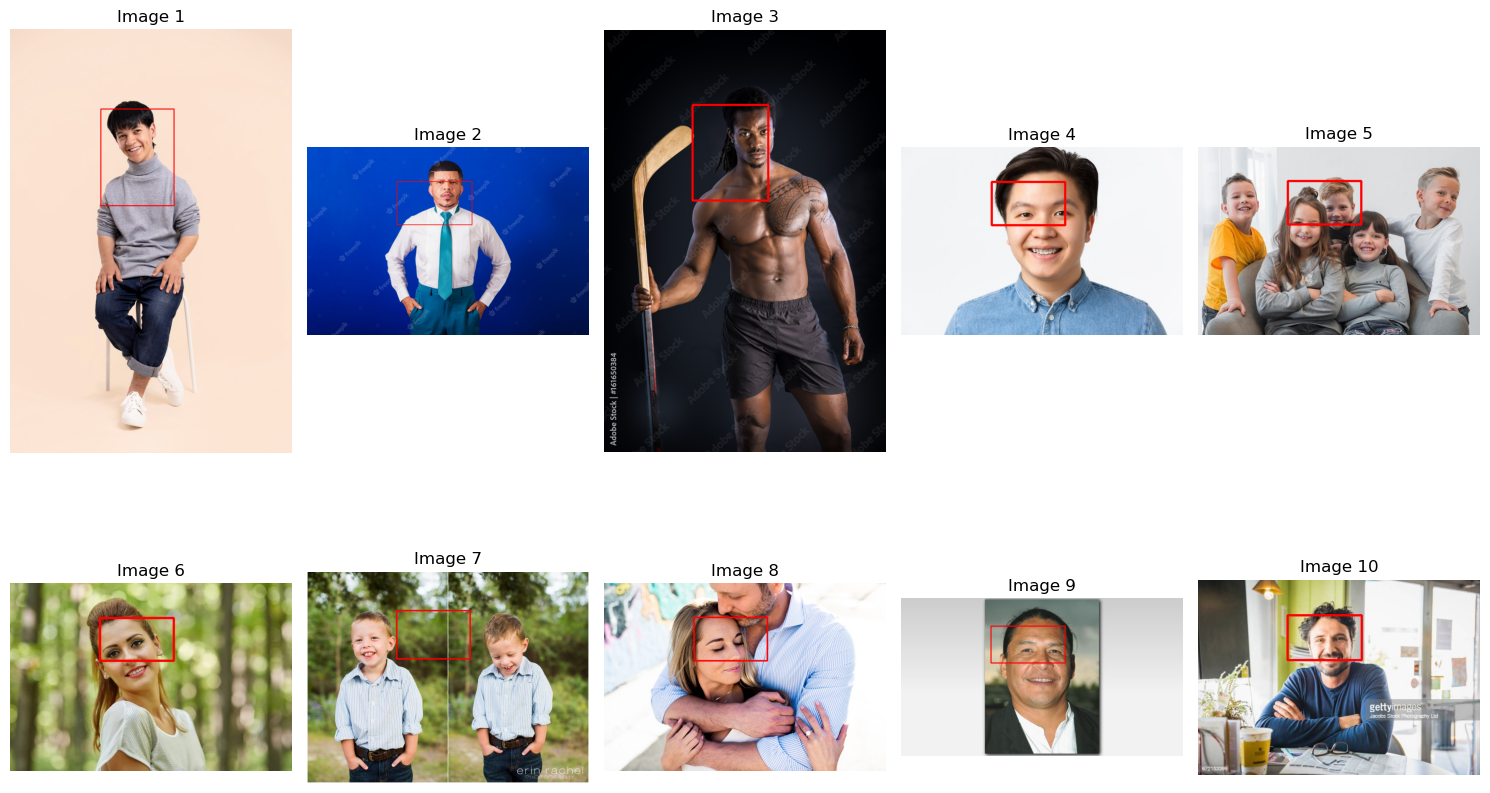

In [32]:
def predict_and_visualize_multiple(img_paths):
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(img_paths):
        # Preprocess image
        test_img, width, height = preprocessing(img_path, None, pred=True)
        test_img = tf.reshape(test_img, (1, 224, 224, 3))

        # Make prediction
        pred = model.predict(test_img)

        # Read the image
        imr = cv2.imread(img_path)
        imr = cv2.cvtColor(imr, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Scale predictions back to original image dimensions
        x0 = int(pred[0][0] * width)
        y0 = int(pred[0][1] * height)
        x1 = int(pred[0][2] * width)
        y1 = int(pred[0][3] * height)

        # Draw rectangle on image
        p1 = (x0, y0)
        p2 = (x1, y1)
        color = (255, 0, 0)
        thickness = 3
        cv2.rectangle(imr, p1, p2, color, thickness)

        # Display the image in a grid
        plt.subplot(2, 5, i + 1)  # Adjust grid size based on the number of images
        plt.imshow(imr)
        plt.axis('off')
        plt.title(f'Image {i + 1}')

    plt.tight_layout()
    plt.show()

# Example usage with the first 10 images
image_folder = 'images'
image_files = os.listdir(image_folder)
image_paths = [os.path.join(image_folder, img_file) for img_file in image_files[:10]]  # Adjust range as needed

predict_and_visualize_multiple(image_paths)
